<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Funciones-auxiliares" data-toc-modified-id="Funciones-auxiliares-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Funciones auxiliares</a></span></li><li><span><a href="#Init-data" data-toc-modified-id="Init-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Init data</a></span><ul class="toc-item"><li><span><a href="#Estaciones" data-toc-modified-id="Estaciones-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Estaciones</a></span></li><li><span><a href="#Data-Mediciones" data-toc-modified-id="Data-Mediciones-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Data Mediciones</a></span></li><li><span><a href="#Ozono" data-toc-modified-id="Ozono-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Ozono</a></span></li><li><span><a href="#Población" data-toc-modified-id="Población-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Población</a></span></li><li><span><a href="#Manzanas-Zonas-Metropolitanas" data-toc-modified-id="Manzanas-Zonas-Metropolitanas-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Manzanas Zonas Metropolitanas</a></span></li></ul></li><li><span><a href="#Población-por-zona-metropolitana" data-toc-modified-id="Población-por-zona-metropolitana-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Población por zona metropolitana</a></span></li><li><span><a href="#Elevación" data-toc-modified-id="Elevación-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Elevación</a></span></li><li><span><a href="#Población-a-3-km-de-la-estación" data-toc-modified-id="Población-a-3-km-de-la-estación-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Población a 3 km de la estación</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

from tqdm import tqdm_notebook
import requests
import json

pd.options.mode.chained_assignment = None

from axo_src.utils import calcular_areas_influencia, agg_info_por_area, wgs84_to_web_mercator, get_local_from_s3

%matplotlib inline

# Funciones auxiliares

In [2]:
# Variable global que usaremos como identificador de las tiendas en la tabla0
ID_COLUMN = 'estacionesid'

# Variable global donde vamos a guardar los features generados
path_features_axo = '/data/axo-promoda/processed/features'
path_tabla0='/data/calidad_aire_presidencia/data_estaciones_sinaica_cvegeo.csv'

# Necesitamos lat, lon para calcular las areas de influencia alrededor de cada sucursal
tabla0 = pd.read_csv(path_tabla0, usecols = [ID_COLUMN, 'lat', 'long', 'cvegeo'])

def calcula_residente_influencia(df_residente, tabla0=tabla0,
                                 radio_residente=3):

    """Calcula la población residente dentro del radio de influencia. Regresa también agregados: abc y abcmen"""

    df_areas_residente = calcular_areas_influencia(tabla0, ID_COLUMN, 'lat', 'long', radio_residente, max_rad=5)
    agg_residente = agg_info_por_area(df_areas_residente, df_residente, 'cvegeo', ID_COLUMN, 'sum')

    feature = tabla0.merge(agg_residente, on=ID_COLUMN,
                           how='left').drop(['lat', 'long'], axis=1)

    # Vamos a renombrar las columnas en area de influencia con formato 'nombre_radio' en metros
    parsed_radio = int(radio_residente*1000)
    parsed_radio = str(parsed_radio)+'m'
    current_names = agg_residente.drop(ID_COLUMN, axis=1).columns.tolist()
    agg_names = [x+'_%s' %parsed_radio for x in current_names]

    # Cambiamos nombre de columnas
    names_dict = dict(zip(current_names, agg_names))
    feature.rename(columns=names_dict, inplace=True)

    return feature

# Init data

## Estaciones

In [3]:
estaciones = pd.read_csv('/data/calidad_aire_presidencia/data_estaciones_sinaica_cvegeo.csv')
mask = (estaciones.lat.between(14, 34.5)) & (estaciones.long.between(-120, -70))
estaciones = estaciones[mask].rename(columns={'id':'estacionesid'})

print(estaciones.shape)
estaciones.head()

(180, 10)


,estacionesid,cvegeo,radius,_id,lat,long,nombre,codigo,redesid,date-insert
0,58,1000500013698027,0.001,5b8850e3e2705c1932e8300b,24.034472,-104.645028,ITD,ITD,42,2018-08-30 20:17:39.219
1,59,1000500014573001,0.001,5b8850e3e2705c1932e8300c,24.051556,-104.611361,IPN,IPN,42,2018-08-30 20:17:39.219
2,60,1000500015266011,0.001,5b8850e3e2705c1932e8300d,24.026778,-104.692975,SRNyMA,SRN,42,2018-08-30 20:17:39.219
3,65,1000700010166050,0.001,5b8850e3e2705c1932e8300e,25.551222,-103.502528,Campestre,CAM,43,2018-08-30 20:17:39.219
4,68,1100700010226014,0.001,5b8850e3e2705c1932e83011,20.517500,-100.815556,Policía,POL,45,2018-08-30 20:17:39.219


## Data Mediciones

In [4]:
mediciones = pd.read_csv('/data/calidad_aire_presidencia/data_mediciones_todas_estaciones_2.csv')
print(mediciones.shape)
mediciones.head()

(3240000, 8)


,city,estacionesid,fecha,hora,parametro,state,validoorig,valororig
0,Durango,58,2018-08-01,13,PM10,Durango,1,988.61
1,Durango,58,2018-08-01,14,PM10,Durango,1,988.61
2,Durango,58,2018-08-01,15,PM10,Durango,1,988.60
3,Durango,58,2018-08-01,16,PM10,Durango,1,988.63
4,Durango,58,2018-08-01,17,PM10,Durango,1,988.63


In [5]:
estaciones_ciudad = mediciones[['city', 'state', 'estacionesid']].drop_duplicates()
estaciones_ciudad = estaciones_ciudad.merge(estaciones[['estacionesid', 'lat', 'long', 'nombre']],
                                            on='estacionesid')
print(estaciones_ciudad.shape)
estaciones_ciudad.head()

(121, 6)


,city,state,estacionesid,lat,long,nombre
0,Durango,Durango,58,24.034472,-104.645028,ITD
1,Durango,Durango,59,24.051556,-104.611361,IPN
2,Durango,Durango,60,24.026778,-104.692975,SRNyMA
3,Gómez Palacio,Durango,65,25.551222,-103.502528,Campestre
4,Celaya,Guanajuato,68,20.517500,-100.815556,Policía


In [6]:
estaciones_ciudad.groupby('city').estacionesid.nunique().sort_values(ascending=False).head()

city
Valle de México    32
Monterrey          11
Guadalajara        10
Toluca              6
León                3
Name: estacionesid, dtype: int64

## Ozono

In [7]:
medicion_contaminante = mediciones[mediciones.parametro=='O3']

# De acuerdo al análisis anterior, es buena idea filtrar valores demasiado grandes. Vamos a usar
# como filtro el mínimo valor de ozono para establecer calidad del aire muy mala según SEMARNAT que es 0.6 ppm
medicion_contaminante = medicion_contaminante[medicion_contaminante.valororig.between(0, 0.7)]

medicion_contaminante = medicion_contaminante.groupby('estacionesid').agg({'valororig':['mean', 'count'],
                                                                           'validoorig':'mean'}).reset_index()
medicion_contaminante.columns = ['estacionesid', 'valororig', 'num_registros', 'validoorig']

medicion_contaminante = medicion_contaminante.merge(estaciones[['estacionesid', 'lat', 'long', 'nombre']],
                                                    on='estacionesid')
medicion_contaminante = medicion_contaminante.merge(mediciones[['estacionesid', 'city']].drop_duplicates(),
                                                    on='estacionesid')

print(medicion_contaminante.shape)
medicion_contaminante.head()

(107, 8)


,estacionesid,valororig,num_registros,validoorig,lat,long,nombre,city
0,33,0.290461,143,1,21.883781,-102.295825,Centro,Aguascalientes
1,38,0.039118,2,1,32.631317,-115.444631,UABC,Mexicali
2,39,0.017146,5858,1,32.639722,-115.506389,COBACH,Mexicali
3,41,0.010098,365,1,32.603639,-115.485944,CESPM,Mexicali
4,46,0.021328,9040,1,32.529461,-116.921281,Laboratorio,Tijuana


In [8]:
mask = (medicion_contaminante.num_registros>2400)
filtered_medicion = medicion_contaminante[mask]

print(filtered_medicion.shape)
filtered_medicion.head()

(96, 8)


,estacionesid,valororig,num_registros,validoorig,lat,long,nombre,city
2,39,0.017146,5858,1,32.639722,-115.506389,COBACH,Mexicali
4,46,0.021328,9040,1,32.529461,-116.921281,Laboratorio,Tijuana
5,53,0.031892,8795,1,28.632775,-106.038867,SUR,Chihuahua
6,54,0.038020,4970,1,28.652228,-106.085358,Centro,Chihuahua
7,56,0.011542,5583,1,25.522694,-103.395806,CONALEP,Torreón


## Población

In [9]:
df_residente = pd.read_csv('/data/opi_data/opi_nse_admin5_2017.csv')
df_residente = df_residente.pivot('cvegeo', 'variable', 'valor')
df_residente.columns = df_residente.columns.str.lower()
df_residente = df_residente.fillna(0).drop(np.nan, axis=1).reset_index()
df_residente['pob_tot'] = df_residente[['pob_ab', 'pob_c', 'pob_cmas', 'pob_cmen', 'pob_d',
       'pob_dmas', 'pob_e']].sum(1)

df_residente.drop(['pob_ab', 'pob_c', 'pob_cmas', 'pob_cmen', 'pob_d', 'pob_dmas', 'pob_e'], axis=1, inplace=True)

print(df_residente.shape)
df_residente.head()

(2323131, 2)


variable,cvegeo,pob_tot
0,0100100010229001,77.789134
1,0100100010229002,0.000000
2,0100100010229003,0.000000
3,0100100010229004,0.000000
4,0100100010229006,25.929711


## Manzanas Zonas Metropolitanas

In [10]:
guadalajara_mnz = gpd.read_file('/home/fickincool/Escritorio/shapes/mnz_zonas_metro_2016/zm_Guadalajara')
print(guadalajara_mnz.shape)
guadalajara_mnz.head()

(54118, 5)


,cvegeo,tipo,cvemun,zona_met,geometry
0,1410101881963800,Caserío Disperso,14101,Guadalajara,(POLYGON ((-103.2616548203058 20.6992963995447...
1,1412000560123800,Caserío Disperso,14120,Guadalajara,(POLYGON ((-103.4067395796593 20.8337961095740...
2,1410101422552800,Caserío Disperso,14101,Guadalajara,(POLYGON ((-103.2313047403976 20.5612279998585...
3,1412001530015800,Caserío Disperso,14120,Guadalajara,(POLYGON ((-103.5798034902669 20.9096736301016...
4,1409800030012800,Caserío Disperso,14098,Guadalajara,(POLYGON ((-103.4131147799056 20.5608117200612...


In [11]:
toluca_mnz = gpd.read_file('/home/fickincool/Escritorio/shapes/mnz_zonas_metro_2016/zm_Toluca')
monterrey_mnz = gpd.read_file('/home/fickincool/Escritorio/shapes/mnz_zonas_metro_2016/zm_Monterrey')
vallemex_mnz = gpd.read_file('/home/fickincool/Escritorio/shapes/mnz_zonas_metro_2016/zm_ValleMexico')

In [12]:
mnz_zonasMet = pd.concat([guadalajara_mnz, toluca_mnz, vallemex_mnz, monterrey_mnz])
print(mnz_zonasMet.shape)
mnz_zonasMet.head()

(306288, 6)


,cvegeo,cvemun,geometry,tipo,tipomza,zona_met
0,1410101881963800,14101,(POLYGON ((-103.2616548203058 20.6992963995447...,Caserío Disperso,NaN,Guadalajara
1,1412000560123800,14120,(POLYGON ((-103.4067395796593 20.8337961095740...,Caserío Disperso,NaN,Guadalajara
2,1410101422552800,14101,(POLYGON ((-103.2313047403976 20.5612279998585...,Caserío Disperso,NaN,Guadalajara
3,1412001530015800,14120,(POLYGON ((-103.5798034902669 20.9096736301016...,Caserío Disperso,NaN,Guadalajara
4,1409800030012800,14098,(POLYGON ((-103.4131147799056 20.5608117200612...,Caserío Disperso,NaN,Guadalajara


# Población por zona metropolitana

In [13]:
_estaciones = filtered_medicion[filtered_medicion.city.isin(['Valle de México', 'Guadalajara',
                                                             'Monterrey', 'Toluca'])].estacionesid

aux = estaciones[estaciones.estacionesid.isin(_estaciones)]
aux['cvemun'] = aux.cvegeo.map(lambda x: str(x)[0:5])

for c in aux.cvemun:
    try:
        val = mnz_zonasMet.loc[mnz_zonasMet.cvemun==c, 'zona_met'].unique()[0]
        aux.loc[aux.cvemun==c, 'zona_met'] = val
    except IndexError:
        pass

# La manzana que le asignamos a la estacion 301 está en la zona metro de Toluca, aunque
# en sinaica la reportan como que está en el DF.
aux.head()

,estacionesid,cvegeo,radius,_id,lat,long,nombre,codigo,redesid,date-insert,cvemun,zona_met
26,101,1412000010354022,0.001,5b8850e3e2705c1932e83027,20.719674,-103.355435,Atemajac,ATM,63,2018-08-30 20:17:39.219,14120,Guadalajara
27,102,1403900011645001,0.001,5b8850e3e2705c1932e83028,20.673765,-103.333336,Centro,CEN,63,2018-08-30 20:17:39.219,14039,Guadalajara
28,103,1412000010706036,0.001,5b8850e3e2705c1932e83029,20.631268,-103.416431,Las Águilas,AGU,63,2018-08-30 20:17:39.219,14120,Guadalajara
29,104,140700013005A019,0.003,5b8850e3e2705c1932e8302a,20.576824,-103.326529,Las Pintas,PIN,63,2018-08-30 20:17:39.219,14070,Guadalajara
30,105,1410100010823038,0.012,5b8850e3e2705c1932e8302b,20.629295,-103.263974,Loma Dorada,LDO,63,2018-08-30 20:17:39.219,14101,Guadalajara


In [14]:
mask = (mediciones.parametro=='O3') & (mediciones.estacionesid.isin(_estaciones))

mediciones_zonasMet = mediciones[mask].merge(aux[['estacionesid', 'cvemun', 'zona_met']], on='estacionesid')
print(mediciones_zonasMet.shape)
mediciones_zonasMet.head()

(251605, 10)


,city,estacionesid,fecha,hora,parametro,state,validoorig,valororig,cvemun,zona_met
0,Guadalajara,101,2018-01-01,1,O3,Jalisco,1,0.008105,14120,Guadalajara
1,Guadalajara,101,2018-01-01,2,O3,Jalisco,1,0.007569,14120,Guadalajara
2,Guadalajara,101,2018-01-01,3,O3,Jalisco,1,0.001316,14120,Guadalajara
3,Guadalajara,101,2018-01-01,4,O3,Jalisco,1,0.002411,14120,Guadalajara
4,Guadalajara,101,2018-01-01,5,O3,Jalisco,1,0.000932,14120,Guadalajara


In [15]:
pob_zonasMet = df_residente.merge(mnz_zonasMet, on='cvegeo')
pob_zonasMet = pob_zonasMet.groupby('zona_met').pob_tot.sum().reset_index()
pob_zonasMet

,zona_met,pob_tot
0,Guadalajara,4.896186e+06
1,Monterrey,4.595478e+06
2,Toluca,2.249951e+06
3,Valle de México,2.155799e+07


In [16]:
mediciones_100mil = mediciones_zonasMet.merge(pob_zonasMet, on='zona_met')
mediciones_100mil['valor_100mil'] = 1e5*mediciones_100mil.valororig/mediciones_100mil.pob_tot
print(mediciones_100mil.shape)
mediciones_100mil.head()

(251605, 12)


,city,estacionesid,fecha,hora,parametro,state,validoorig,valororig,cvemun,zona_met,pob_tot,valor_100mil
0,Guadalajara,101,2018-01-01,1,O3,Jalisco,1,0.008105,14120,Guadalajara,4.896186e+06,0.000166
1,Guadalajara,101,2018-01-01,2,O3,Jalisco,1,0.007569,14120,Guadalajara,4.896186e+06,0.000155
2,Guadalajara,101,2018-01-01,3,O3,Jalisco,1,0.001316,14120,Guadalajara,4.896186e+06,0.000027
3,Guadalajara,101,2018-01-01,4,O3,Jalisco,1,0.002411,14120,Guadalajara,4.896186e+06,0.000049
4,Guadalajara,101,2018-01-01,5,O3,Jalisco,1,0.000932,14120,Guadalajara,4.896186e+06,0.000019


Text(0,0.5,'ppm')

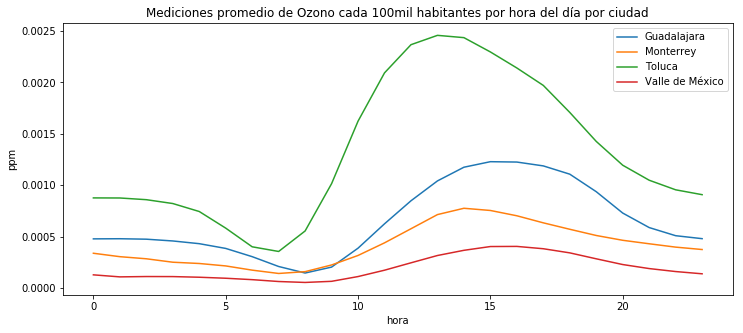

In [17]:
for i, g in mediciones_100mil.groupby('city'):
    g.groupby('hora').valor_100mil.mean().plot(figsize=(12, 5), label=i, legend=True)
    
plt.title('Mediciones promedio de Ozono cada 100mil habitantes por hora del día por ciudad')
plt.ylabel('ppm')

# Elevación

In [18]:
def get_elevation(coords_list):
    
    elevation_url = 'https://api.open-elevation.com/api/v1/lookup'
    header = {'Accept':'application/json', 'Content-Type':'application/json'}
    data = {'locations':coords_list}

    resp = requests.post(elevation_url, headers=header, data=json.dumps(data))
    
    if resp.status_code==200:
        return json.loads(resp.text)['results']
    
    else:
        return

In [71]:
_estaciones = filtered_medicion[filtered_medicion.city.isin(['Valle de México', 'Guadalajara',
                                                             'Monterrey', 'Toluca'])].estacionesid

aux = estaciones[estaciones.estacionesid.isin(_estaciones)]
aux['cvemun'] = aux.cvegeo.map(lambda x: str(x)[0:5])

for c in aux.cvemun:
    try:
        val = mnz_zonasMet.loc[mnz_zonasMet.cvemun==c, 'zona_met'].unique()[0]
        aux.loc[aux.cvemun==c, 'zona_met'] = val
    except IndexError:
        print('ERROR', c)
        pass
    
# Vamos a llenar este campo
aux['elevacion'] = -1

print(aux.shape)
aux.head()

(52, 13)


,estacionesid,cvegeo,radius,_id,lat,long,nombre,codigo,redesid,date-insert,cvemun,zona_met,elevacion
26,101,1412000010354022,0.001,5b8850e3e2705c1932e83027,20.719674,-103.355435,Atemajac,ATM,63,2018-08-30 20:17:39.219,14120,Guadalajara,-1
27,102,1403900011645001,0.001,5b8850e3e2705c1932e83028,20.673765,-103.333336,Centro,CEN,63,2018-08-30 20:17:39.219,14039,Guadalajara,-1
28,103,1412000010706036,0.001,5b8850e3e2705c1932e83029,20.631268,-103.416431,Las Águilas,AGU,63,2018-08-30 20:17:39.219,14120,Guadalajara,-1
29,104,140700013005A019,0.003,5b8850e3e2705c1932e8302a,20.576824,-103.326529,Las Pintas,PIN,63,2018-08-30 20:17:39.219,14070,Guadalajara,-1
30,105,1410100010823038,0.012,5b8850e3e2705c1932e8302b,20.629295,-103.263974,Loma Dorada,LDO,63,2018-08-30 20:17:39.219,14101,Guadalajara,-1


In [33]:
aux.zona_met.value_counts()

Valle de México    31
Guadalajara        10
Toluca              7
Monterrey           4
Name: zona_met, dtype: int64

In [79]:
_low = [i*4 for i in range(0, 13)]
_hi = [i*4 for i in range(1, 14)]

chunks = [aux[i:j] for i, j in zip(_low, _hi)]

,estacionesid,cvegeo,radius,_id,lat,long,nombre,codigo,redesid,date-insert,cvemun,zona_met,elevacion
30,105,1410100010823038,0.012,5b8850e3e2705c1932e8302b,20.629295,-103.263974,Loma Dorada,LDO,63,2018-08-30 20:17:39.219,14101,Guadalajara,-1
31,106,1403900014673027,0.001,5b8850e3e2705c1932e8302c,20.614444,-103.343333,Miravalle,MIR,63,2018-08-30 20:17:39.219,14039,Guadalajara,-1
32,107,1403900010505003,0.001,5b8850e3e2705c1932e8302d,20.700539,-103.296617,Oblatos,OBL,63,2018-08-30 20:17:39.219,14039,Guadalajara,-1
33,108,1409700381795004,0.001,5b8850e3e2705c1932e8302e,20.529149,-103.377179,Santa Fe,SFE,63,2018-08-30 20:17:39.219,14097,Guadalajara,-1


In [92]:
count=0
for chunk in chunks:
    lats = chunk.lat.values
    lons = chunk.long.values
    ids = chunk.estacionesid.values

    coords_list = []
    for i in range(0, len(ids)):
        coords_list.append({'latitude':lats[i], 'longitude':lons[i]})
        
    print(coords_list)

    aux_elevation = get_elevation(coords_list)
    
    if aux_elevation is not None:
        for e, r in zip(ids, results):
            aux['elevacion'] = np.where(aux.estacionesid==e, r['elevation'], aux.elevacion)
            
    else:
        print('No se encontraron datos para el chunk', count)
        
    count+=1
    print('\n\n')

[{'latitude': 20.719673888889, 'longitude': -103.35543472222}, {'latitude': 20.673764722222, 'longitude': -103.33333611111}, {'latitude': 20.631268055556, 'longitude': -103.41643083333}, {'latitude': 20.576823888889, 'longitude': -103.32652861111}]



[{'latitude': 20.629294722222, 'longitude': -103.26397416667}, {'latitude': 20.614444444444, 'longitude': -103.34333333333001}, {'latitude': 20.700538611111, 'longitude': -103.29661666667}, {'latitude': 20.529149444444002, 'longitude': -103.37717944444}]



[{'latitude': 20.640966666666998, 'longitude': -103.31259194444}, {'latitude': 20.680193055556, 'longitude': -103.39855138889}, {'latitude': 19.260305555556, 'longitude': -99.645722222222}, {'latitude': 19.278083333333, 'longitude': -99.656416666667}]



[{'latitude': 19.270194444444, 'longitude': -99.595194444444}, {'latitude': 19.283444444444, 'longitude': -99.683488888889}, {'latitude': 19.327222222221998, 'longitude': -99.634288888889}, {'latitude': 19.280416666666998, 'longitude':

In [95]:
aux.sort_values('elevacion', ascending=False).head()

,estacionesid,valororig,num_registros,validoorig,lat,long,nombre,city,elevacion
20,242,0.039463,4554,1,19.272222,-99.207778,Ajusco Medio,Valle de México,1621
10,123,0.031440,5187,1,19.260306,-99.645722,Ceboruco,Toluca,1621
37,262,0.037142,4558,1,19.357500,-99.263056,Santa Fe,Valle de México,1621
32,256,0.032010,4972,1,19.424722,-99.119722,Merced,Valle de México,1621
31,254,0.031438,4530,1,19.578889,-99.039722,Los Laureles,Valle de México,1621


In [96]:
# aux.to_csv('/data/calidad_aire_presidencia/data_estaciones_elevacion_zonas_metro_grandes.csv', index=False)

In [19]:
elevacion_data = pd.read_csv('/data/calidad_aire_presidencia/data_estaciones_elevacion_zonas_metro_grandes.csv')
elevacion_data.sort_values('elevacion', ascending=False).head()

,estacionesid,cvegeo,radius,_id,lat,long,nombre,codigo,redesid,date-insert,cvemun,zona_met,elevacion
26,256,0901700010704006,0.001,5b8850e3e2705c1932e83078,19.424722,-99.119722,Merced,MER,119,2018-08-30 20:17:39.225,9017,Valle de México,1621
42,241,0901200192460002,1.611,5b8850e3e2705c1932e8306a,19.154286,-99.162778,Ajusco,AJU,119,2018-08-30 20:17:39.225,9012,Valle de México,1621
18,242,0901200011462002,0.001,5b8850e3e2705c1932e8306b,19.272222,-99.207778,Ajusco Medio,AJM,119,2018-08-30 20:17:39.225,9012,Valle de México,1621
30,262,0900400010369011,0.001,5b8850e3e2705c1932e8307e,19.357500,-99.263056,Santa Fe,SFE,119,2018-08-30 20:17:39.225,9004,Valle de México,1621
14,127,1510600664776017,0.001,5b8850e3e2705c1932e8303a,19.327222,-99.634289,San Cristobal,SC,65,2018-08-30 20:17:39.219,15106,Toluca,1621


In [20]:
elevacion_data[elevacion_data.nombre=='Pedregal']

,estacionesid,cvegeo,radius,_id,lat,long,nombre,codigo,redesid,date-insert,cvemun,zona_met,elevacion
28,259,0901000011294007,0.001,5b8850e3e2705c1932e8307b,19.325278,-99.204167,Pedregal,PED,119,2018-08-30 20:17:39.225,9010,Valle de México,1524


In [21]:
aux = filtered_medicion.merge(elevacion_data[['estacionesid', 'elevacion']], on='estacionesid')
aux.corr()

,estacionesid,valororig,num_registros,validoorig,lat,long,elevacion
estacionesid,1.000000,0.103179,0.015060,NaN,0.053395,0.691258,0.007531
valororig,0.103179,1.000000,0.116088,NaN,-0.685986,0.143264,0.142237
num_registros,0.015060,0.116088,1.000000,NaN,-0.135101,-0.043553,0.027062
validoorig,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,0.053395,-0.685986,-0.135101,NaN,1.000000,-0.318622,-0.220887
long,0.691258,0.143264,-0.043553,NaN,-0.318622,1.000000,0.087810
elevacion,0.007531,0.142237,0.027062,NaN,-0.220887,0.087810,1.000000


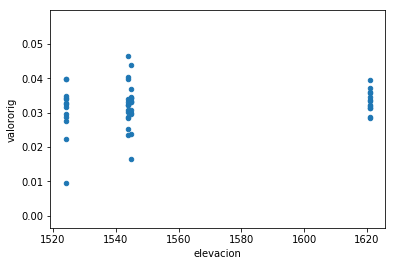

In [22]:
aux.plot.scatter('elevacion', 'valororig')

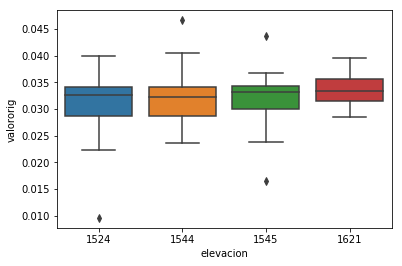

In [23]:
import seaborn as sns
sns.boxplot('elevacion', 'valororig', data=aux)

# Población a 3 km de la estación

In [24]:
tabla0[tabla0.estacionesid.isin(filtered_medicion.estacionesid)].shape

(96, 4)

In [30]:
tabla0_aux = tabla0[tabla0.estacionesid.isin(filtered_medicion.estacionesid)]

aux = filtered_medicion.copy()

for radio in [1, 3, 5]:
    pob_areaInfluencia = calcula_residente_influencia(df_residente, tabla0_aux, radio)
    aux = aux.merge(pob_areaInfluencia.drop('cvegeo', axis=1), on='estacionesid')
    
aux = aux.merge(elevacion_data[['estacionesid', 'elevacion']], on='estacionesid')
print(aux.shape)
aux.head()

(52, 12)


,estacionesid,valororig,num_registros,validoorig,lat,long,nombre,city,pob_tot_1000m,pob_tot_3000m,pob_tot_5000m,elevacion
0,101,0.029474,4063,1,20.719674,-103.355435,Atemajac,Guadalajara,42225.476342,325976.419618,767443.235974,1524
1,102,0.032310,5711,1,20.673765,-103.333336,Centro,Guadalajara,42628.658868,309449.264480,885518.326138,1544
2,103,0.032200,5678,1,20.631268,-103.416431,Las Águilas,Guadalajara,40443.858869,274135.840094,703105.817729,1621
3,104,0.029983,5484,1,20.576824,-103.326529,Las Pintas,Guadalajara,15721.208197,146354.117887,378170.922377,1545
4,105,0.028688,3066,1,20.629295,-103.263974,Loma Dorada,Guadalajara,61986.188294,323274.643403,743848.464560,1524


In [31]:
aux['pob_tot_elev'] = aux.pob_tot_5000m/aux.elevacion

In [32]:
aux[aux.estacionesid.isin(_estaciones)].corr()

,estacionesid,valororig,num_registros,validoorig,lat,long,pob_tot_1000m,pob_tot_3000m,pob_tot_5000m,elevacion,pob_tot_elev
estacionesid,1.000000,0.103179,0.015060,NaN,0.053395,0.691258,-0.076332,0.046994,0.110846,0.007531,0.107744
valororig,0.103179,1.000000,0.116088,NaN,-0.685986,0.143264,0.085064,0.093964,0.162536,0.142237,0.160248
num_registros,0.015060,0.116088,1.000000,NaN,-0.135101,-0.043553,-0.055874,0.113265,0.216044,0.027062,0.215530
validoorig,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,0.053395,-0.685986,-0.135101,NaN,1.000000,-0.318622,-0.222900,-0.251051,-0.264380,-0.220887,-0.259740
long,0.691258,0.143264,-0.043553,NaN,-0.318622,1.000000,-0.046378,0.048695,0.057384,0.087810,0.053226
pob_tot_1000m,-0.076332,0.085064,-0.055874,NaN,-0.222900,-0.046378,1.000000,0.875722,0.715451,0.103952,0.718388
pob_tot_3000m,0.046994,0.093964,0.113265,NaN,-0.251051,0.048695,0.875722,1.000000,0.935498,0.073845,0.937163
pob_tot_5000m,0.110846,0.162536,0.216044,NaN,-0.264380,0.057384,0.715451,0.935498,1.000000,0.119386,0.998684
elevacion,0.007531,0.142237,0.027062,NaN,-0.220887,0.087810,0.103952,0.073845,0.119386,1.000000,0.073913


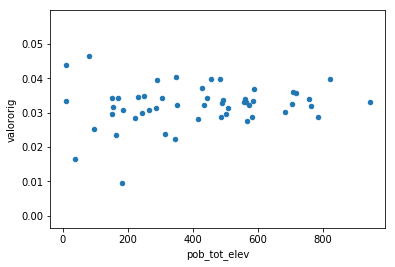

In [33]:
aux[aux.estacionesid.isin(_estaciones)].plot.scatter('pob_tot_elev', 'valororig')